In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_classification

In [3]:
def gaussian_kernel(x, mu=0, sigma=1):
    return 1 / (((2 * np.pi) ** 0.5) * sigma) * np.exp(-(x - mu) ** 2 / (2 * sigma.astype(np.float64) ** 2))

class BMANBClassifier:
    """
    BMA-NB классификатор. Предполагается, что распределение всех признаков нормальное
    """
    def __init__(self, beta=1, coef=2):
        self.beta = beta
        
        # константа нормализации
        self.coef = coef
        
        # количество классов
        self.m = None
        
        # массив меток классов размерности (m, ) (m - число классов)
        self.labels = None
        
        # массив априорных вероятностей классов размерности (m, )
        self.cls_probs = None
        
        # размерность признакового пространства
        self.k = None
    
        # массив средних размерности (m, k) (k - число признаков)
        self.mus = None
        
        # массив стандартных отклонений размерности (m, k)
        self.sigmas = None
        
        # массив величин A_k размерности (1, k)
        self.a = None
        
        # массив величин B_k размерности (1, k)
        self.b = None
    
    def fit(self, X, y, coef=None):
        """
        X - признаковое описание объектов: np.array размерности (n, k) 
        (n - количество объектов,  k - размерность признакового пространства)
        y - метки классов: np.array размерности (n, ) 
        
        Вычисляем self.cls_probs, self.mus, self.sigmas, self.a, self.b
        returns: self
        """
        if coef != None:
            self.coef = coef
        # размер обучающей выборки
        n = y.shape[0]
        
        # размерность признакового пространства
        self.k = X.shape[1]
        
        # массив меток классов
        self.labels = np.unique(y)
        
        # количество классов
        self.m = self.labels.shape[0]
        
        # вычисление априорных вероятностей классов, параметров распределения для каждого класса и каждого признака
        self.cls_probs = np.zeros(self.m)
        self.mus = np.zeros((self.m, self.k))
        self.sigmas = np.zeros((self.m, self.k))
        for i, label in enumerate(self.labels):
            self.cls_probs[i] = (y == label).sum() / n
            
            # признаковое описание объектов с меткой label
            X_cls = X[y == label]
            
            # вычисление мат.ожиданий и стандартных отклонений сразу по всем признакам
            self.mus[i] = X_cls.mean(axis=0)
            self.sigmas[i] = (((X_cls - self.mus[i]) ** 2).sum(axis=0) / X_cls.shape[0]) ** 0.5  
        
        # занумеруем классы для удобства дальнйших вычислений
        y_nums = np.zeros(n).astype(int)
        for i, label in enumerate(self.labels):
            y_nums[np.where(y == label)] = i
            
        # вычисление коэффициентов A_k и B_k
        self.a = np.zeros(self.k).astype(np.float64)
        self.b = np.zeros(self.k).astype(np.float64)
        # рассматриваем j-й признак
        for j in range(self.k):
            arr = np.tile(X[:, j].reshape((-1,)), (self.m, 1))
            # вычисляем P(x_{ij} | y_j) для всех y_q, q = 1,...,m
            for q, label in enumerate(self.labels):
                arr[q] = gaussian_kernel(arr[q], self.mus[q, j], self.sigmas[q, j])
            
            vec_a = (self.coef * np.transpose(arr) * self.cls_probs).sum(axis=1)
            vec_b = (self.coef * gaussian_kernel(X[:, j], self.mus[:, j][y_nums], self.sigmas[:, j][y_nums]))
            
            norm_coef = 10 ** np.median(np.log10(np.hstack([vec_a, vec_b]).flatten()))
            vec_a /= norm_coef
            vec_b /= norm_coef
            self.a[j] = vec_a.prod()
            self.b[j] = vec_b.prod()
            
        return self
        
    
    def predict(self, X=None):
        """
        X - признаковое описание объектов: np.array размерности (n, k) 
        returns: np.array размерности (n,) - метки классов для соответствующих объектов из X
        """
        n = X.shape[0]
        
        # Вычисление P(x_{id} | y_j) и P(x_{id}) для всех i = 1, ..., n, d = 1, ..., k, j = 1, ..., m
        prob_arr = np.zeros((n, self.m + 1, self.k))
        
        for i in range(n):
            for j in range(self.m):
                prob_arr[i][j] = gaussian_kernel(X[i], self.mus[j], self.sigmas[j])
            prob_arr[i][self.m] = (prob_arr[i][:-1] * self.cls_probs[:, None]).sum()
        
        # строим прогноз...
        result = np.zeros(n)
        for i in range(n):
            l = np.log10(self.a * np.tile(prob_arr[i][self.m], (self.m, 1)) + self.b / self.beta * prob_arr[i][:-1])
            result[i] = self.labels[np.argmax(l.sum(axis=1) + np.log10(self.cls_probs))]
            
        
        return result

In [4]:
def kfold_split(num_objects, num_folds):
    indexes = np.arange(num_objects)
    delims = np.arange(0, num_objects // num_folds * num_folds, num_objects // num_folds)[1:]
    folds = np.split(indexes, delims)
    
    l = []
    for i in range(num_folds):
        l.append((np.delete(indexes, folds[i]), folds[i]))

    return l

def cross_val(model, X, y, cv=5, score_function=accuracy_score, seed=0):
    folds = kfold_split(X.shape[0], cv)
    np.random.seed(seed)
    indexes = np.random.permutation(X.shape[0])
    X, y = X[indexes], y[indexes]
    accuracy_list = []
    for train_fold, test_fold in folds:
        model.fit(X[train_fold], y[train_fold])
        y_pred = model.predict(X[test_fold])
        accuracy_list.append(score_function(y[test_fold], y_pred))
        
    return np.array(accuracy_list)

### Test 0

In [5]:
from sklearn.datasets import load_iris

data = load_iris()
X = data["data"]
y = data["target"]

print("GaussianNB. Тосность по кросс-валидации на 5 фолдах:", cross_val_score(GaussianNB(), X, y, cv=5).mean())
print("BMA-NB. Тосность по кросс-валидации на 5 фолдах:", cross_val(BMANBClassifier(coef=1, beta=1), X, y, cv=5).mean())
print("SVC. Тосность по кросс-валидации на 5 фолдах:", cross_val_score(SVC(), X, y, cv=5).mean())

GaussianNB. Тосность по кросс-валидации на 5 фолдах: 0.9533333333333334
BMA-NB. Тосность по кросс-валидации на 5 фолдах: 0.9533333333333334
SVC. Тосность по кросс-валидации на 5 фолдах: 0.9666666666666666


### Test 1

In [6]:
bmanb_list = []
nb_list = []
svc_list = []

for state in range(5):
    
    X, y = make_classification(n_samples=1500, n_features=5, 
                               n_informative=5, n_redundant=0, n_repeated=0,
                               n_clusters_per_class=1, n_classes=2,
                               random_state=state)

    bmanb_list.append(cross_val(BMANBClassifier(), X, y, cv=5, seed=2).mean())
    nb_list.append(cross_val_score(GaussianNB(), X, y, scoring="accuracy", cv=5).mean())
    svc_list.append(cross_val_score(SVC(), X, y, scoring="accuracy", cv=5).mean())
#     print(state)


0
1
2
3
4


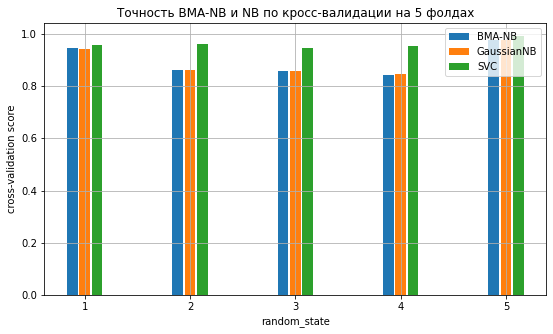

In [7]:
# задаем размеры
plt.figure(figsize=(9,5))

# заголовок 
plt.title('Точность BMA-NB и NB по кросс-валидации на 5 фолдах')

# ширина столбцов
width = 0.35

# координаты столбцов
ids = np.arange(1, 6)

# рисуем графики
plt.bar(ids - width / 3, bmanb_list, width / 3.5, label="BMA-NB")
plt.bar(ids, nb_list, width / 3.5, label="GaussianNB")
plt.bar(ids + width / 3, svc_list, width / 3.5, label='SVC')

# подписи осей
plt.xlabel('random_state')
plt.ylabel('cross-validation score')

plt.legend()

# сетка графика
plt.grid(True) 

plt.show()

### Test 2

In [8]:
bmanb_list = []
nb_list = []
svc_list = []

for state in range(5):
    
    X, y = make_classification(n_samples=3000, n_features=20, 
                               n_informative=5, n_redundant=5, n_repeated=5,
                               n_clusters_per_class=1, n_classes=3,
                               random_state=state)

    bmanb_list.append(cross_val(BMANBClassifier(), X, y, cv=5, seed=2).mean())
    nb_list.append(cross_val_score(GaussianNB(), X, y, scoring="accuracy", cv=5).mean())
    svc_list.append(cross_val_score(SVC(), X, y, scoring="accuracy", cv=5).mean())
    print(state)


0
1
2
3
4


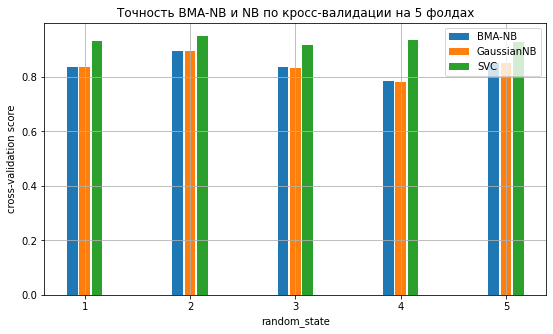

In [9]:
# задаем размеры
plt.figure(figsize=(9,5))

# заголовок 
plt.title('Точность BMA-NB и NB по кросс-валидации на 5 фолдах')

# ширина столбцов
width = 0.35

# координаты столбцов
ids = np.arange(1, 6)

# рисуем графики
plt.bar(ids - width / 3, bmanb_list, width / 3.5, label="BMA-NB")
plt.bar(ids, nb_list, width / 3.5, label="GaussianNB")
plt.bar(ids + width / 3, svc_list, width / 3.5, label='SVC')

# подписи осей
plt.xlabel('random_state')
plt.ylabel('cross-validation score')

plt.legend()

# сетка графика
plt.grid(True) 

plt.show()

### Test 3

In [10]:
bmanb_list = []
nb_list = []
svc_list = []

for state in range(5):
    
    X, y = make_classification(n_samples=1500, n_features=500, 
                               n_informative=30, n_redundant=3,
                               n_clusters_per_class=1, n_classes=2,
                               random_state=state)

    bmanb_list.append(cross_val(BMANBClassifier(), X, y, cv=5, seed=2).mean())
    nb_list.append(cross_val_score(GaussianNB(), X, y, scoring="accuracy", cv=5).mean())
    svc_list.append(cross_val_score(SVC(), X, y, scoring="accuracy", cv=5).mean())
    print(state)


0
1
2
3
4


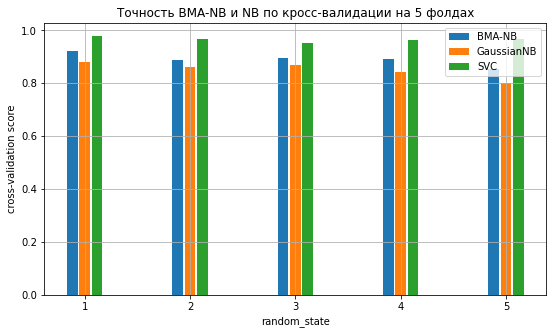

In [11]:
# задаем размеры
plt.figure(figsize=(9,5))

# заголовок 
plt.title('Точность BMA-NB и NB по кросс-валидации на 5 фолдах')

# ширина столбцов
width = 0.35

# координаты столбцов
ids = np.arange(1, 6)

# рисуем графики
plt.bar(ids - width / 3, bmanb_list, width / 3.5, label="BMA-NB")
plt.bar(ids, nb_list, width / 3.5, label="GaussianNB")
plt.bar(ids + width / 3, svc_list, width / 3.5, label='SVC')

# подписи осей
plt.xlabel('random_state')
plt.ylabel('cross-validation score')

plt.legend()

# сетка графика
plt.grid(True) 

plt.show()

### Test 4

In [12]:
bmanb_list = []
nb_list = []
svc_list = []

for state in range(5):
    X, y = make_classification(n_samples=2000, n_features=500, 
                               n_informative=30, n_redundant=3,
                               n_clusters_per_class=1, n_classes=3,
                               random_state=state)

    bmanb_list.append(cross_val(BMANBClassifier(), X, y, cv=5, seed=2).mean())
    nb_list.append(cross_val_score(GaussianNB(), X, y, scoring="accuracy", cv=5).mean())
    svc_list.append(cross_val_score(SVC(), X, y, scoring="accuracy", cv=5).mean())
    print(state)


0
1
2
3
4


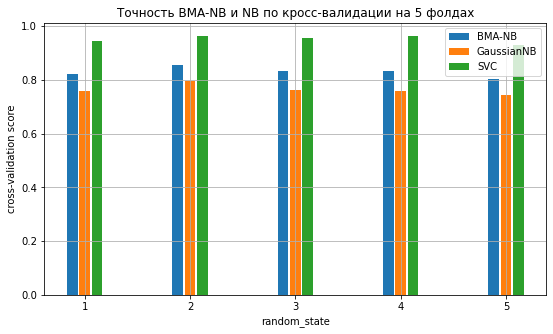

In [13]:
# задаем размеры
plt.figure(figsize=(9,5))

# заголовок 
plt.title('Точность BMA-NB и NB по кросс-валидации на 5 фолдах')

# ширина столбцов
width = 0.35

# координаты столбцов
ids = np.arange(1, 6)

# рисуем графики
plt.bar(ids - width / 3, bmanb_list, width / 3.5, label="BMA-NB")
plt.bar(ids, nb_list, width / 3.5, label="GaussianNB")
plt.bar(ids + width / 3, svc_list, width / 3.5, label='SVC')

# подписи осей
plt.xlabel('random_state')
plt.ylabel('cross-validation score')

plt.legend()

# сетка графика
plt.grid(True) 

plt.show()

### Test 5

In [14]:
bmanb_list = []
nb_list = []
svc_list = []

for state in range(5):
    
    X, y = make_classification(n_samples=2000, n_features=500, 
                               n_informative=30, n_redundant=3,
                               n_clusters_per_class=1, n_classes=5,
                               random_state=state)

    bmanb_list.append(cross_val(BMANBClassifier(), X, y, cv=5, seed=2).mean())
    nb_list.append(cross_val_score(GaussianNB(), X, y, scoring="accuracy", cv=5).mean())
    svc_list.append(cross_val_score(SVC(), X, y, scoring="accuracy", cv=5).mean())
    print(state)


0
1
2
3
4


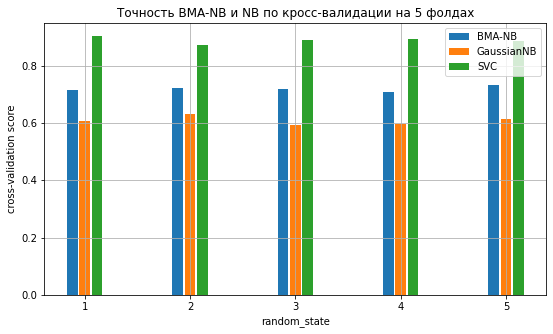

In [15]:
# задаем размеры
plt.figure(figsize=(9,5))

# заголовок 
plt.title('Точность BMA-NB и NB по кросс-валидации на 5 фолдах')

# ширина столбцов
width = 0.35

# координаты столбцов
ids = np.arange(1, 6)

# рисуем графики
plt.bar(ids - width / 3, bmanb_list, width / 3.5, label="BMA-NB")
plt.bar(ids, nb_list, width / 3.5, label="GaussianNB")
plt.bar(ids + width / 3, svc_list, width / 3.5, label='SVC')

# подписи осей
plt.xlabel('random_state')
plt.ylabel('cross-validation score')

plt.legend()

# сетка графика
plt.grid(True) 

plt.show()